In [5]:
import sqlite3
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import h5py
import yaml
from ipywidgets import interactive, IntSlider, fixed

In [6]:
class Results_Loader:
    def __init__(self, name, results_path, feat_names, color):
        self.name = name
        self.results_path = results_path
        self.feat_names = feat_names
        self.cursor = sqlite3.connect(results_path + "results.db").cursor()
        self.get_params()
        self.color = color
    
    def get_params(self):
        self.param_ids = dict()
        self.param_map = dict()
        self.cursor.execute('SELECT param_name, param_id FROM param_ids')
        for param_name, param_id in self.cursor.fetchall():
            param_val = int(float(yaml.load(open(self.results_path + param_name), Loader = yaml.BaseLoader)['params']['n_features_to_select']))
            self.param_map[param_val]= param_id
            self.param_ids[param_id] = param_val
    
    def get_vals_at_n(self,n):
        vals = defaultdict(list)
        self.cursor.execute(f'SELECT key, stat FROM statistics WHERE param_id={self.param_map[n]} AND LENGTH(key) < 4')
        for key, stat in self.cursor.fetchall():
            vals[key].append(stat)
        return vals
    
    def get_percents_at_n(self,n):
        vals = self.get_vals_at_n(n)
        percents = [None for i in range(len(vals))]
        for val in vals:
            percents[int(val)] = np.sum(np.array(vals[val]) == 1.0) / len(vals[val])
        return percents
    
    def get_stat_values(self, key):
        n_feat_key = defaultdict(list)
        self.cursor.execute(f'SELECT param_id, stat FROM statistics WHERE key="{key}"')
        for param_id, stat in self.cursor.fetchall():
            n_feat_key[self.param_ids[param_id]].append(stat)
        return n_feat_key
    
    def get_stats(self, key):
        vals = self.get_stat_values(key)
        ns = []
        mean = []
        std = []
        for n in vals:
            ns.append(n)
            mean.append(np.mean(vals[n]))
            std.append(np.std(vals[n]))
        sort = np.argsort(ns)
        ns = np.array(ns)[sort]
        mean = np.array(mean)[sort]
        std = np.array(std)[sort]
        return (ns, mean, std)

In [7]:
data_path_90 = "/data/MLIA_active_data/data_barefoot/domine/full_rock/Barefoot.h5"
data_path_350 = "/data/MLIA_active_data/data_barefoot/domine/full_rock_v2/Barefoot.h5"

In [8]:
data = h5py.File(data_path_90,mode='r')
names_90 = [str(i,'utf-8') for i in data["features"]]
data.close()

data = h5py.File(data_path_350,mode='r')
names_350 = [str(i,'utf-8') for i in data["features"]]
data.close()

In [98]:
results = {
#     "rf_90": Results_Loader("Random Forest 90","/home/phorton/Barefoot_Rover/domine_runs/rfe_rf_90/",names_90, "red"),
    "rf_350": Results_Loader("Random Forest 350","/home/phorton/Barefoot_Rover/domine_runs/rfe_rf_350/",names_350, "blue"),
#     "lr_90": Results_Loader("Logistic Regression 90","/home/phorton/Barefoot_Rover/domine_runs/rfe_lr_90/",names_90),
    "lr_350": Results_Loader("Logistic Regression 350","/home/phorton/Barefoot_Rover/domine_runs/rfe_lr_350/",names_350,"red"),
}

In [92]:
def feature_percent(results, n_features_to_select):
    percents = results.get_percents_at_n(n_features_to_select)
    plt.figure(num=None, figsize=(50, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'Percentage of Feature Occurance with {n_features_to_select} Features to Select in RFE with {results.name}')
    plt.ylabel("Percent Occurance")
    plt.ylim((0,1))
    plt.xticks(rotation='vertical')
    plt.bar(results.feat_names,percents)

In [13]:
interactive(feature_percent,results=fixed(results["rf_90"]),n_features_to_select=IntSlider(min=1,max=90,step=1,continuous_update=False))

interactive(children=(IntSlider(value=1, continuous_update=False, description='n_features_to_select', max=90, …

In [94]:
name_to_dim_ratio = 20/96
plot_to_height_ratio = 3/2
def range_plot(results,ns):
    plts, axs = plt.subplots(len(ns),1, sharex=True, figsize = (name_to_dim_ratio*len(results.feat_names),(plot_to_height_ratio*len(ns))+3))
    axs[0].set_title(f'Percentage Feature Occurance using RFE with {results.name} Estimator')
    for i in range(len(axs)):
        percents = results.get_percents_at_n(ns[i])
        axs[i].set_ylim((0,1))
        axs[i].bar(results.feat_names,percents)
        axs[i].set_ylabel(f'% in top {ns[i]}')

    plt.xticks(rotation='vertical')
    plt.show()

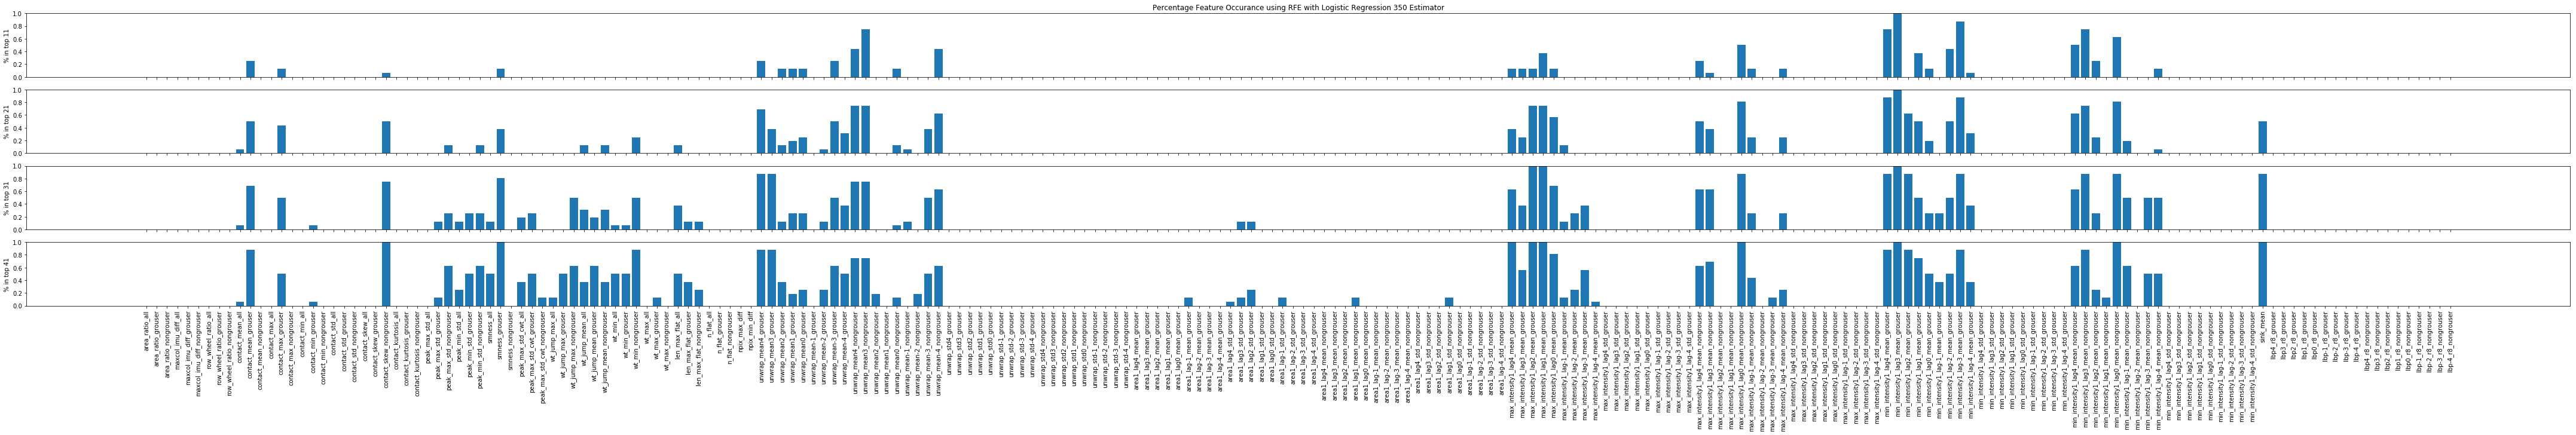

In [96]:
range_plot(results["lr_350"],[11,21,31,41])

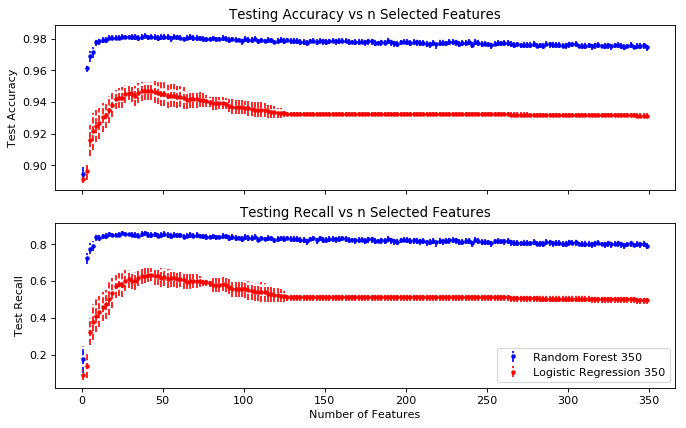

In [100]:
plts, (acc_plot, rec_plot) = plt.subplots(2,1, sharex=True, num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel("Number of Features")


for result in results:
    ns, mean_acc, std_acc = results[result].get_stats("test_acc")
    ns, mean_rec, std_rec = results[result].get_stats("test_rec")
    acc_err = acc_plot.errorbar(ns,mean_acc,yerr=std_acc,ecolor=results[result].color,fmt='.',color=results[result].color)
    acc_err[-1][0].set_linestyle('--')

    rec_err = rec_plot.errorbar(ns,mean_rec,yerr=std_rec,ecolor=results[result].color,fmt='.',color=results[result].color)
    rec_err[-1][0].set_linestyle('--')

acc_plot.set_title(f"Testing Accuracy vs n Selected Features")
acc_plot.set_ylabel("Test Accuracy")

rec_plot.set_title(f"Testing Recall vs n Selected Features")
rec_plot.set_ylabel("Test Recall")
plt.legend([results[result].name for result in results])
plt.show()